# 3. 시각화 예제

> plot.ly 라이브러리를 활용하여 간단한 시각화 예제를 시도해 보았습니다

In [1]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
from IPython.display import display, display_pretty, clear_output, JSON

spark = (
    SparkSession
    .builder
    .config("spark.sql.session.timeZone", "Asia/Seoul")
    .getOrCreate()
)

# 노트북에서 테이블 형태로 데이터 프레임 출력을 위한 설정을 합니다
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # display enabled
spark.conf.set("spark.sql.repl.eagerEval.truncate", 100) # display output columns size

# 공통 데이터 위치
home_jovyan = "/home/jovyan"
work_data = f"{home_jovyan}/work/data"
work_dir=!pwd
work_dir = work_dir[0]
answer = "/answer"

# 로컬 환경 최적화
spark.conf.set("spark.sql.shuffle.partitions", 5) # the number of partitions to use when shuffling data for joins or aggregations.
spark.conf.set("spark.sql.streaming.forceDeleteTempCheckpointLocation", "true")
spark

21/09/08 13:54:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/09/08 13:54:50 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
21/09/08 13:54:50 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


### 시각화 테스트를 위해 3일차 이후 데이터를 생성합니다

> 오늘 이전의 데이터는 유지하고, 신규로 생성된 데이터를 Append 해야 합니다.

In [23]:
# 2020-10-25 ~ 2020-11-03 : 이틀 치는 데이터가 저장되었고 이후 데이터는 임의의 데이터 입력

today = "2020-10-27"
lgde_origin = spark.read.jdbc("jdbc:mysql://mysql:3306/testdb", "testdb.lgde", properties={"user": "sqoop", "password": "sqoop"}).where(col("dt") < lit(today))
lgde_today = (
    spark.createDataFrame(
        [
            ("2020-10-27", 30, 10, 10000000)
            , ("2020-10-28", 40, 25, 50000000)
            , ("2020-10-29", 100, 28, 100000000)
            , ("2020-10-30", 90, 25, 60000000)
            , ("2020-10-31", 150, 10, 160000000)
            , ("2020-11-01", 140, 13, 150000000)
            , ("2020-11-02", 180, 15, 180000000)
            , ("2020-11-03", 160, 12, 170000000)
        ], ["DT", "DAU", "PU", "DR"]
    )
)


lgde_union = lgde_origin.union(lgde_today)
lgde_local = lgde_union.collect()
lgde = spark.createDataFrame(lgde_local)
lgde.write.mode("overwrite").jdbc("jdbc:mysql://mysql:3306/testdb", "testdb.lgde", properties={"user": "sqoop", "password": "sqoop"})

### 3-1. 일자별 접속 및 매출 추세

> 일자별 지표는 레이턴시가 보장되는 관계형 데이터베이스 혹은 NoSQL 에 저장되어 있다고 가정하고, 해당 데이터를 JDBC를 통해 가져온 다음 아래와 같은 리포트를 생성할 수 있습니다.


In [19]:
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline(connected=True)

raw = spark.read.jdbc("jdbc:mysql://mysql:3306/testdb", "testdb.lgde", properties={"user": "sqoop", "password": "sqoop"}).orderBy(asc("dt"))
data = raw.withColumn("ARPU", expr("round(DR / DAU)")).withColumn("ARPPU", expr("round(DR / PU)"))


```javascript
kine = { chart, scatter, bar, box, spread, ratio, heatmap, surface, histogram, bubble, bubble3d, scatter3d, scattergeo, ohlc, candle, pie, choroplet }
dash = { key: value = { solid, dash, dashdot, dot } }
mode = { key: value = { lines, markers, lines+markers, lines+text, markers+text, lines+markers+text } }  : mode 에 text 혹은 markers 지정이 되었을 때에만 text 혹은 symbol 속성 적용이 가능합니다
symbol = { key: value = { circle, circle-dot, diamond, square } } : mode 지정 시에 심볼을 별도로 명시하는 기능
interpolation = { key: value = { linear, spline, vhv, hvh, vh, hv } } 
```

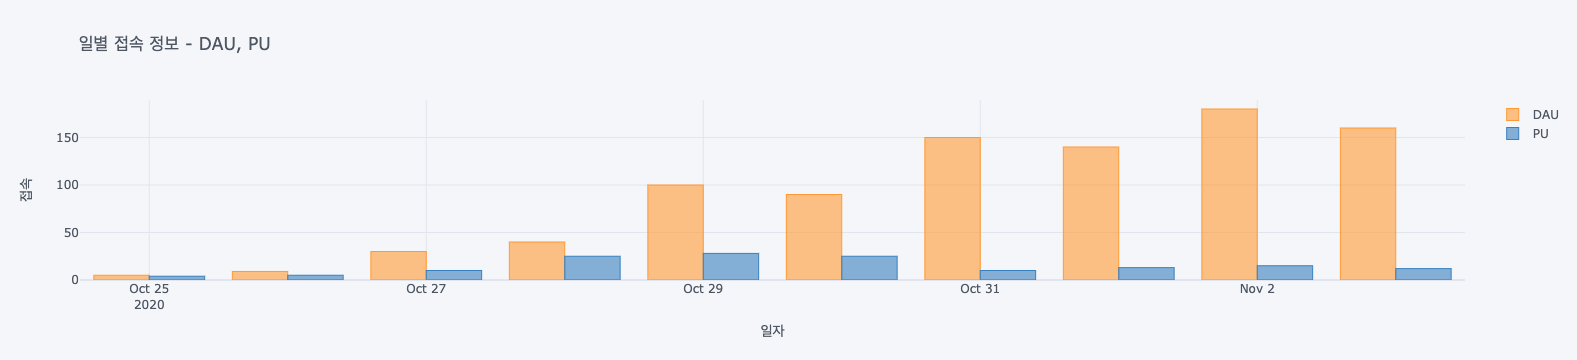

In [20]:
# DAU, PU - 접속
_kind = 'bar'
_barmode = 'group'
_dash = {'DAU':'solid', 'PU':'solid'}
_mode = {'DAU':'lines+markers+text', 'PU':'lines+markers'}
_symbol = {'DAU':'square', 'PU':'circle'}
_interpolation = {'DAU':'spline', 'PU':'spline'}
_size = 8

users = data.withColumn("datetime", to_date(col('DT'), 'yyyy-MM-dd')).drop("DT", "DR", "ARPU", "ARPPU")
pdUsers = users.toPandas().set_index('datetime')
pdUsers.iplot(kind=_kind, barmode=_barmode, title='일별 접속 정보 - DAU, PU', xTitle='일자', yTitle='접속', fill=True, dash=_dash, mode=_mode, symbol=_symbol, interpolation=_interpolation, size=_size)

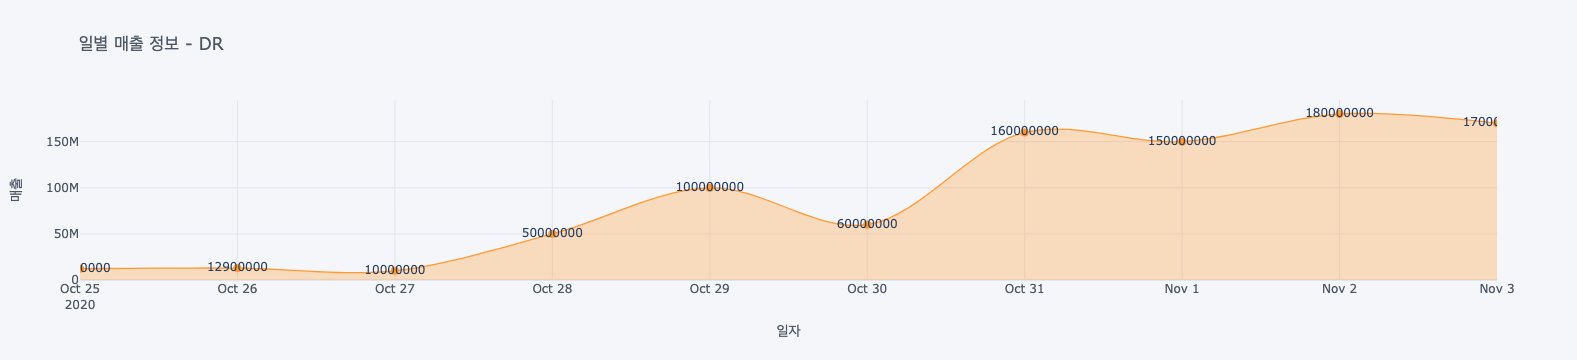

In [21]:
@udf(returnType=StringType()) 
def addComma(column):
    return "{:,}".format(column)

# DR
_kind = 'line'
_dash = {'DR':'solid'}
_mode = {'DR':'lines+markers+text'}
_symbol = {'DR':'circle'}
_interpolation = {'DR':'spline'}
_size = 8
revenue = data.withColumn("datetime", to_date(col('DT'), 'yyyy-MM-dd')).drop("DT", "DAU", "PU", "ARPU", "ARPPU")
pdRevenue = revenue.toPandas().set_index('datetime') # .withColumn("DRC", addComma(col("DR")))
pdRevenue.iplot(kind=_kind, text='DR', title='일별 매출 정보 - DR', xTitle='일자', yTitle='매출', fill=True, \
                dash=_dash, mode=_mode, symbol=_symbol, interpolation=_interpolation, size=_size)

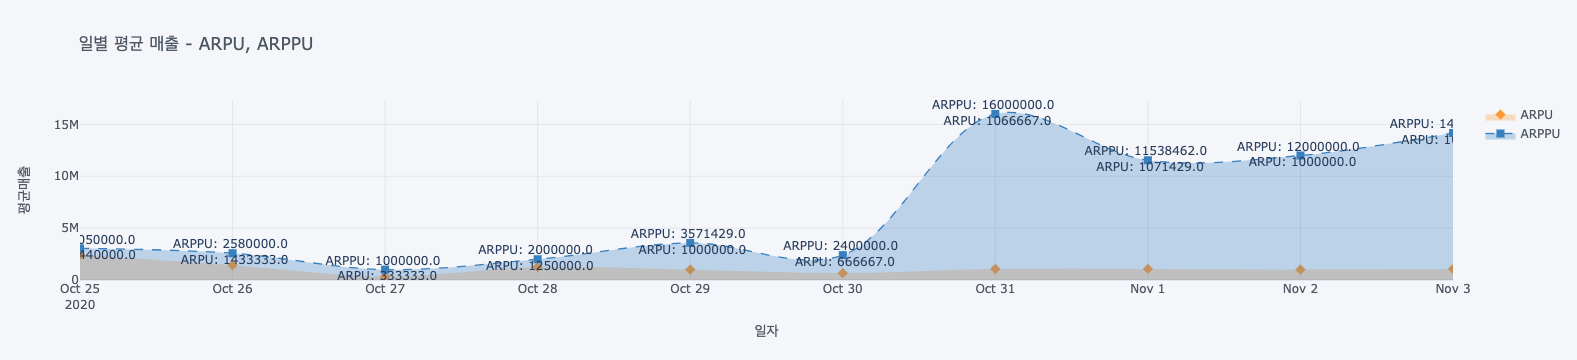

In [22]:
# DR, ARPU, ARPPU - 매출
_kind = 'line'
_dash = {'ARPU':'solid', 'ARPPU':'dash'}
_mode = {'ARPU':'markers', 'ARPPU':'lines+markers+text'}
_symbol = {'ARPU':'diamond', 'ARPPU':'square'}
_interpolation = {'ARPU':'spline', 'ARPPU':'spline'}
_size = 8

purchase = data.withColumn("datetime", to_date(col('DT'), 'yyyy-MM-dd')).drop("DT", "DAU", "PU", "DR")
pdPurchase = purchase.toPandas().set_index('datetime')

arppu = list(pdPurchase['ARPPU'])
arpu = list(pdPurchase['ARPU'])
_text = [f'ARPPU: {x} <br> ARPU: {y}' for x,y in list(zip(arppu, arpu))]

pdPurchase.iplot(kind='line', text=_text, title='일별 평균 매출 - ARPU, ARPPU', xTitle='일자', yTitle='평균매출', fill=True, \
                 dash=_dash, mode=_mode, symbol=_symbol, interpolation=_interpolation, size=_size)

In [13]:
help(pdPurchase.iplot)

Help on method _iplot in module cufflinks.plotlytools:

_iplot(kind='scatter', data=None, layout=None, filename='', sharing=None, title='', xTitle='', yTitle='', zTitle='', theme=None, colors=None, colorscale=None, fill=False, width=None, dash='solid', mode='', interpolation='linear', symbol='circle', size=12, barmode='', sortbars=False, bargap=None, bargroupgap=None, bins=None, histnorm='', histfunc='count', orientation='v', boxpoints=False, annotations=None, keys=False, bestfit=False, bestfit_colors=None, mean=False, mean_colors=None, categories='', x='', y='', z='', text='', gridcolor=None, zerolinecolor=None, margin=None, labels=None, values=None, secondary_y='', secondary_y_title='', subplots=False, shape=None, error_x=None, error_y=None, error_type='data', locations=None, lon=None, lat=None, asFrame=False, asDates=False, asFigure=False, asImage=False, dimensions=None, asPlot=False, asUrl=False, online=None, **kwargs) method of pandas.core.frame.DataFrame instance
           Retur

<br>

### 3-2. 성별 구매 통계

> 디멘젼 테이블을 통해서 성별 구매 금액과 횟수를 시각화 합니다

In [9]:
dimension = spark.read.parquet(f"{work_dir}{answer}/dimension/dt=20201026")
display(dimension)

d_uid,d_name,d_gender,d_acount,d_pamount,d_pcount,d_first_purchase
9,최컴퓨터,남,1,2500000,1,2020-10-26 07:49:15
7,임모바일,남,1,3500000,1,2020-10-26 07:45:55
8,조노트북,여,1,0,0,null
3,박트롬,여,3,1000000,1,2020-10-25 05:42:35
4,청소기,남,5,0,0,null
1,정휘센,남,3,5200000,3,2020-10-25 05:32:30
2,김싸이언,남,5,1400000,1,2020-10-25 11:38:20
5,유코드제로,여,3,7000000,3,2020-10-25 09:32:35
6,윤디오스,남,1,4500000,1,2020-10-26 10:08:20


In [10]:
gender = dimension.select("d_name", "d_gender", "d_pcount", "d_pamount").toPandas()
display(gender)

,d_name,d_gender,d_pcount,d_pamount
0,최컴퓨터,남,1,2500000
1,임모바일,남,1,3500000
2,조노트북,여,0,0
3,박트롬,여,1,1000000
4,청소기,남,0,0
5,정휘센,남,3,5200000
6,김싸이언,남,1,1400000
7,유코드제로,여,3,7000000
8,윤디오스,남,1,4500000


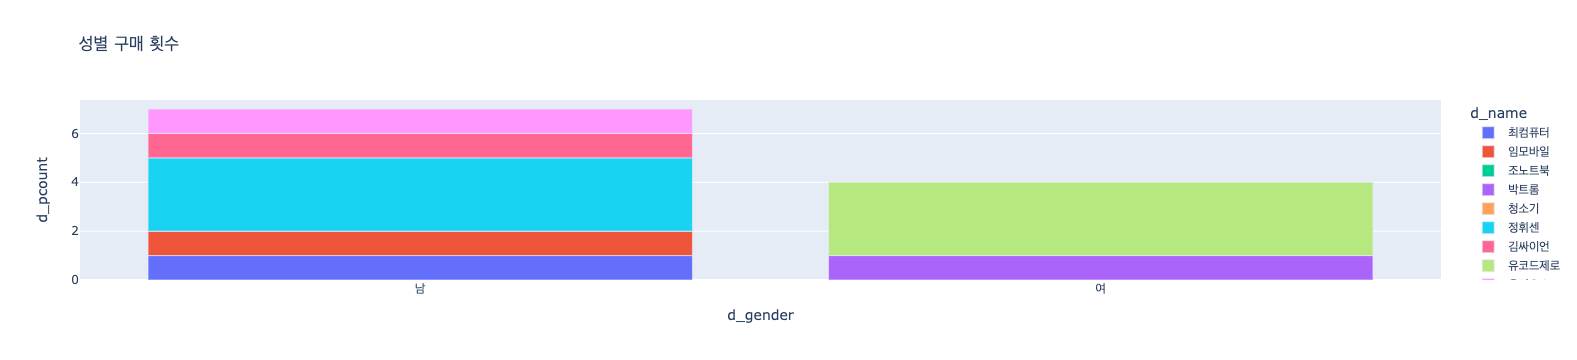

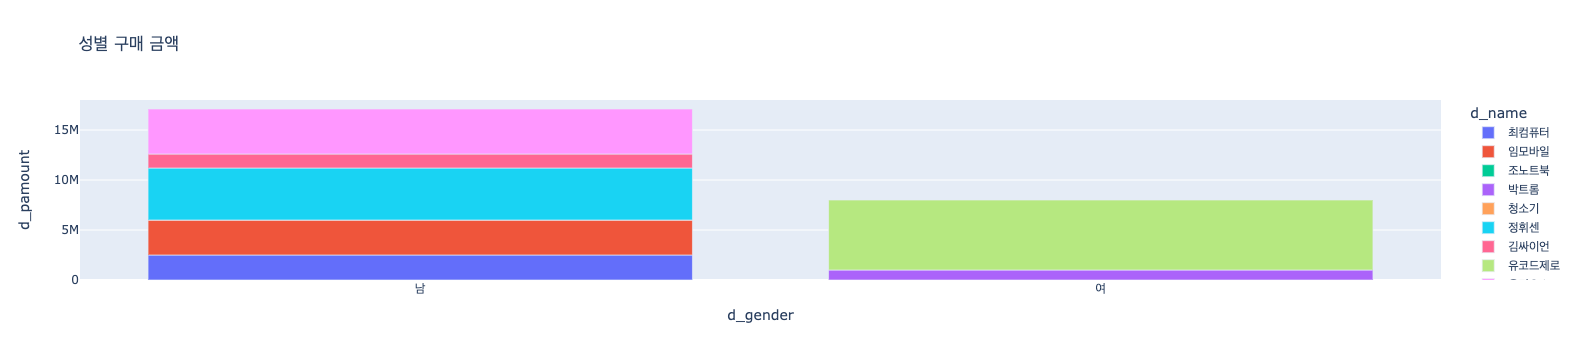

In [11]:
import plotly.express as px

fig = px.bar(gender, x="d_gender", y="d_pcount", color="d_name", title="성별 구매 횟수")
fig.show()

fig = px.bar(gender, x="d_gender", y="d_pamount", color="d_name", title="성별 구매 금액")
fig.show()

<br>

### 3-3. 다양한 시각화 예제

### 참고자료
* [plot.ly bar-charts](https://plotly.com/python/bar-charts/)
* [plot.ly line-charts](https://plotly.com/python/line-charts/)
* [plot.ly express](https://plotly.com/python/px-arguments/)
* [plot.ly w/ apache spark](https://plotly.com/python/v3/apache-spark/)


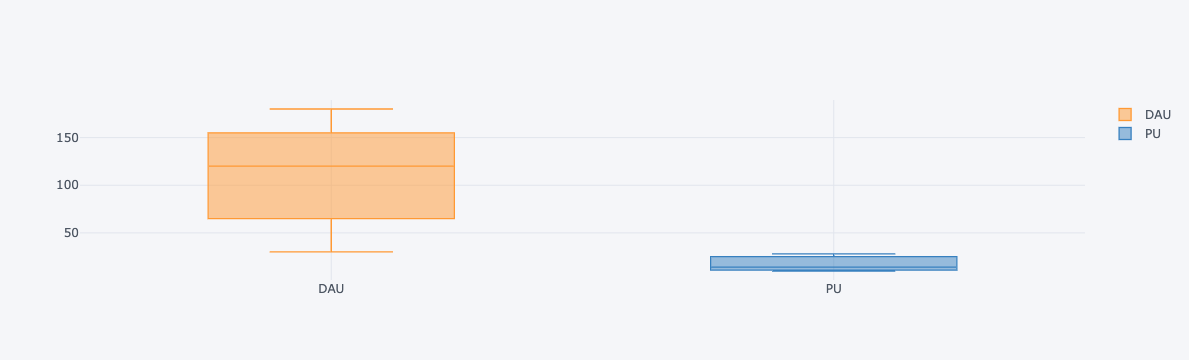

In [12]:
pdUsers.iplot(kind='box')

In [13]:
import numpy as np
users = spark.createDataFrame([("2021-08-01", 30, 10), ("2021-08-02", 40, 28), ("2021-08-03", 100, 10), ("2021-08-04", 90, 30), ("2021-08-05", 150, 50)], ["DATE", "DAU", "DPU"])
users.show(truncate=False)

dt = np.array(users.select("DATE").collect()).reshape(-1)
y1 = np.array(users.select("DAU").collect()).reshape(-1)
y2 = np.array(users.select("DPU").collect()).reshape(-1)


+----------+---+---+
|DATE      |DAU|DPU|
+----------+---+---+
|2021-08-01|30 |10 |
|2021-08-02|40 |28 |
|2021-08-03|100|10 |
|2021-08-04|90 |30 |
|2021-08-05|150|50 |
+----------+---+---+



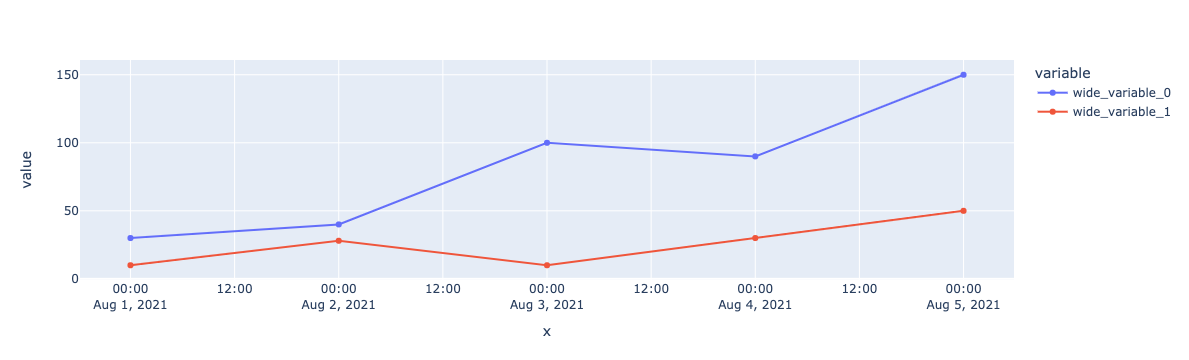

In [14]:
fig = px.line(x=dt, y=[y1, y2], markers=True)
fig.update_traces()
fig.show()

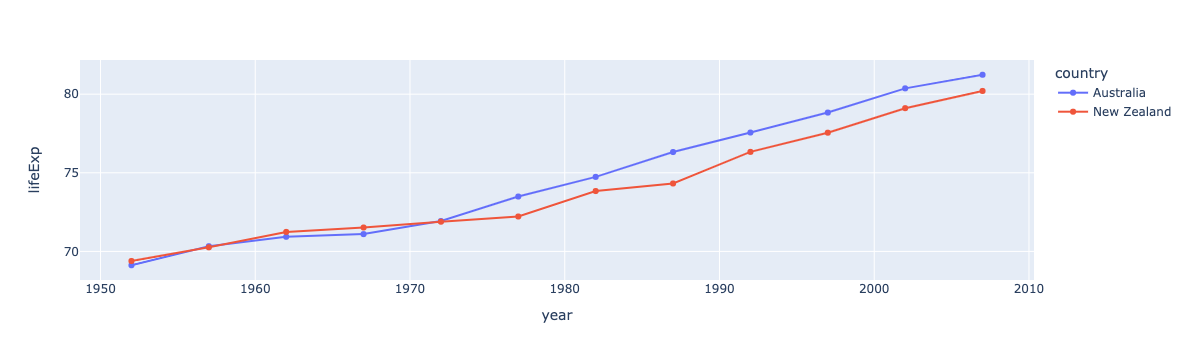

In [15]:
import plotly.express as px
df = px.data.gapminder().query("continent == 'Oceania'")
fig = px.line(df, x='year', y='lifeExp', color='country', markers=True)
fig.show()

In [16]:
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline(connected=True)

In [17]:
pdUsers.head()

,DAU,PU
datetime,,
2021-08-01,30,10
2021-08-02,40,25
2021-08-03,100,28
2021-08-04,90,25
2021-08-05,150,10


In [18]:
df = cf.datagen.lines()
df.head()

,MST.LF,ZLJ.EC,FRN.OH,CHF.DT,ONR.RG
2015-01-01,1.646000,-0.957035,0.109382,-0.448231,-0.037617
2015-01-02,1.509426,-0.337004,0.927018,0.271396,-0.979886
2015-01-03,2.886446,-0.319585,-1.052523,1.322693,0.181529
2015-01-04,3.157752,-0.720623,-1.347637,0.746635,0.743181
2015-01-05,4.664085,-0.446313,1.668729,-0.862617,-0.459035


In [19]:
print(df)

              MST.LF    ZLJ.EC    FRN.OH    CHF.DT     ONR.RG
2015-01-01  1.646000 -0.957035  0.109382 -0.448231  -0.037617
2015-01-02  1.509426 -0.337004  0.927018  0.271396  -0.979886
2015-01-03  2.886446 -0.319585 -1.052523  1.322693   0.181529
2015-01-04  3.157752 -0.720623 -1.347637  0.746635   0.743181
2015-01-05  4.664085 -0.446313  1.668729 -0.862617  -0.459035
...              ...       ...       ...       ...        ...
2015-04-06  1.566699  1.875156  4.898736  2.770628 -14.276211
2015-04-07  0.413490  0.427677  4.816949  2.645884 -13.765856
2015-04-08  1.175292 -1.631982  5.784717  1.501562 -12.347416
2015-04-09  0.338442 -0.744472  4.901484  0.640499 -11.631579
2015-04-10  1.689080 -0.673680  4.580768  0.527162 -11.130009

[100 rows x 5 columns]


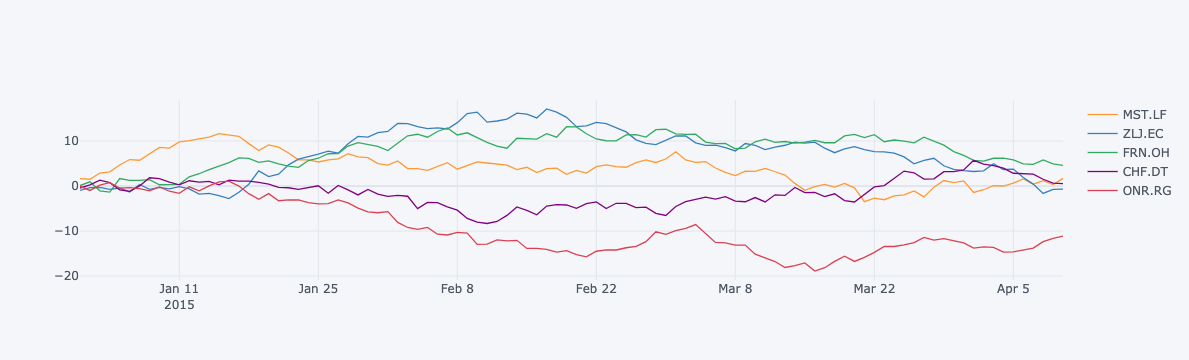

In [20]:
df.iplot(kind='line')

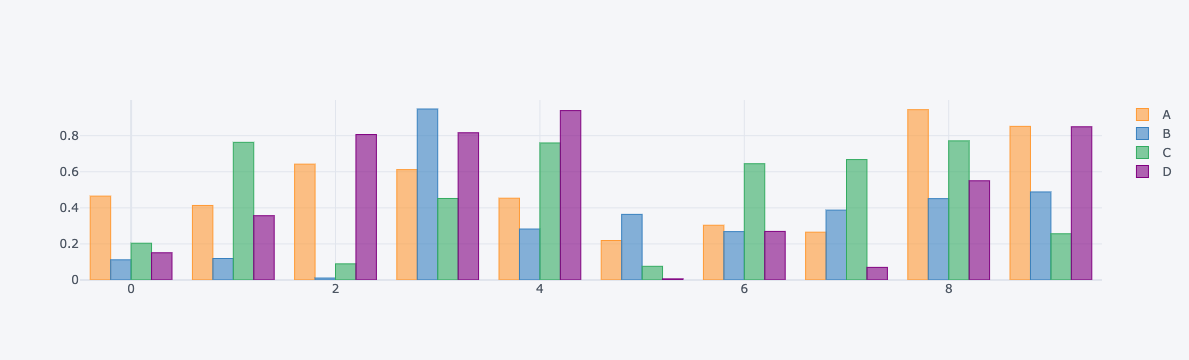

In [21]:
import numpy as np
import pandas as pd
df = pd.DataFrame(np.random.rand(10, 4), columns=['A', 'B', 'C', 'D'])
df.head()
df.iplot(kind='bar')

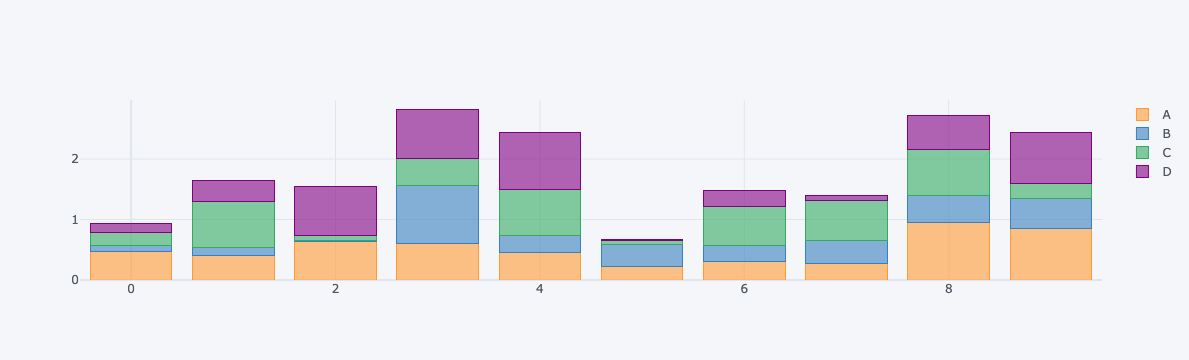

In [22]:
df.iplot(kind='bar', barmode='stack')

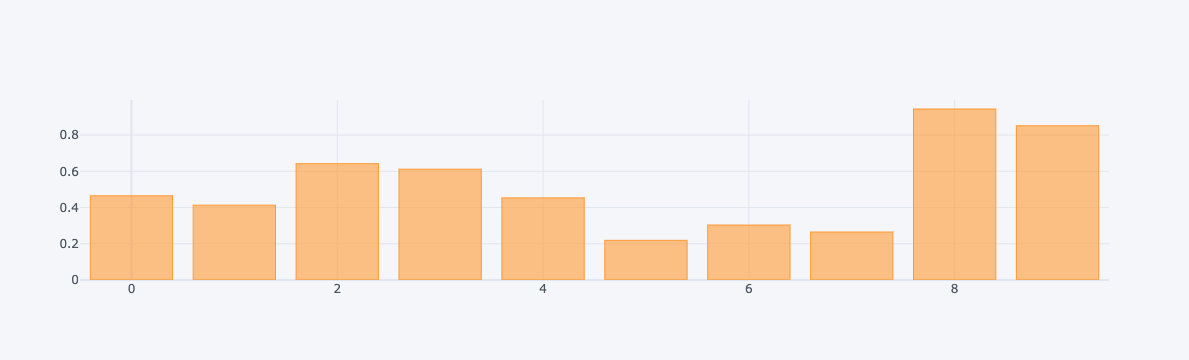

In [23]:
df['A'].iplot(kind='bar')

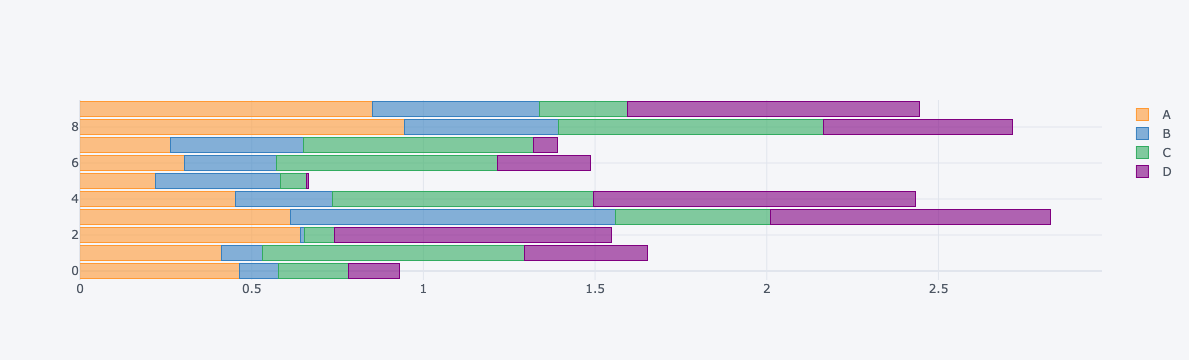

In [24]:
df.iplot(kind='barh', barmode='stack')

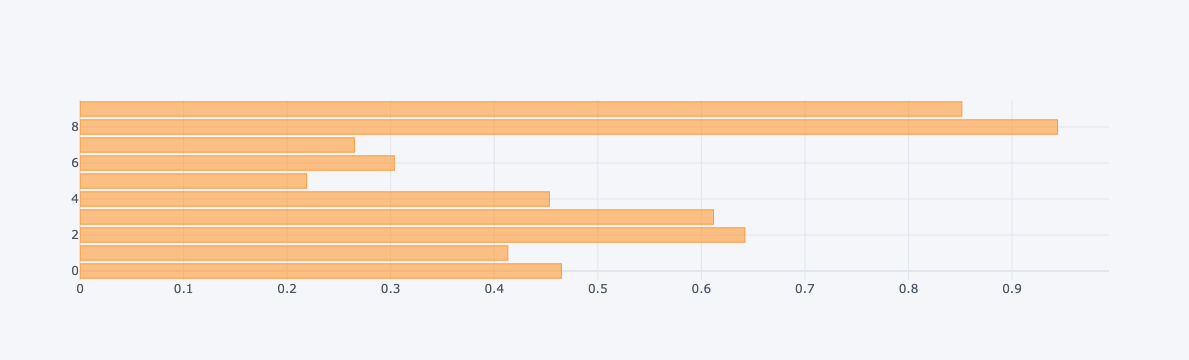

In [25]:

df['A'].iplot(kind='barh')
